# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

[We've provided you with some commentary to guide your thinking as you complete this project. However, make sure to remove all the bracketed comments before submitting your project.]

[Before you dive into analyzing your data, explain for yourself the purpose of the project and actions you plan to take.]

[Please bear in mind that studying, amending, and analyzing data is an iterative process. It is normal to return to previous steps and correct/expand them to allow for further steps.]

## Initialization

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set styles for plots
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


## Load data

In [2]:
calls = pd.read_csv('/datasets/megaline_calls.csv')
calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [3]:
internet = pd.read_csv('/datasets/megaline_internet.csv')
internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [4]:
messages = pd.read_csv('/datasets/megaline_messages.csv')
messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [5]:
plans = pd.read_csv('/datasets/megaline_plans.csv')
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [6]:
users = pd.read_csv('/datasets/megaline_users.csv')
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Prepare the data

[The data for this project is split into several tables. Explore each one to get an initial understanding of the data. Do necessary corrections to each table if necessary.]

In [7]:
# Convert dates
calls['call_date'] = pd.to_datetime(calls['call_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])

# Round each call duration up to the nearest minute
calls['duration'] = np.ceil(calls['duration']).astype(int)

# Add month columns
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

In [8]:
monthly_calls = calls.groupby(['user_id', 'month'])['duration'].sum().reset_index()
monthly_calls.rename(columns={'duration': 'minutes_used'}, inplace=True)

# Total messages per user per month
monthly_messages = messages.groupby(['user_id', 'month']).size().reset_index(name='messages_sent')

# Total MB used per user per month (rounded to GB)
monthly_internet = internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
monthly_internet['gb_used'] = np.ceil(monthly_internet['mb_used'] / 1024).astype(int)
monthly_internet.drop(columns='mb_used', inplace=True)

In [9]:
# Merge all usage tables
monthly_usage = monthly_calls.merge(monthly_messages, how='outer', on=['user_id', 'month'])
monthly_usage = monthly_usage.merge(monthly_internet, how='outer', on=['user_id', 'month'])

# Fill NaN with zeros for users who had no activity that month
monthly_usage.fillna(0, inplace=True)

# Make sure integers are integers
monthly_usage['messages_sent'] = monthly_usage['messages_sent'].astype(int)
monthly_usage['minutes_used'] = monthly_usage['minutes_used'].astype(int)
monthly_usage['gb_used'] = monthly_usage['gb_used'].astype(int)

# Merge with users to bring in plan/city
monthly_usage = monthly_usage.merge(users[['user_id', 'plan', 'city']], on='user_id')


## Plans

In [10]:
# Print the general/summary information about the plans' DataFrame
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [11]:
# Print a sample of data for plans
plans.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


From the `.info()` and `.head()` results:

- There are only 2 rows in the `plans` DataFrame, one for **Surf** and one for **Ultimate**.
- All column types are appropriate: integers and floats for prices/limits, and string (`object`) for `plan_name`.
- There are **no missing values**, so no cleaning is needed here.
- The plan details (limits and prices) will be merged later for calculating each user's revenue.

No issues found 

## Fix data

[Fix obvious issues with the data given the initial observations.]

In [12]:
monthly_usage.isnull().sum()

monthly_usage.dtypes

monthly_usage['messages_sent'] = monthly_usage['messages_sent'].astype(int)
monthly_usage['minutes_used'] = monthly_usage['minutes_used'].astype(int)
monthly_usage['gb_used'] = monthly_usage['gb_used'].astype(int)

We reviewed the merged usage data for missing values and incorrect data types.

- All columns are present and there are no missing values after `.fillna(0)` was applied earlier.
- The columns `minutes_used`, `messages_sent`, and `gb_used` are explicitly cast to integers to avoid float artifacts from operations like `groupby()` and `ceil()`.

## Enrich data

Ended up enirching the dataset by calculating the **monthly revenue per user**.

- Overages for minutes, messages, and data were calculated by subtracting the included amount and clipping negative values to 0.
- All overages were multiplied by their respective rates from the `plans` table.
- Final revenue was computed as:

  `revenue = base fee + extra minutes cost + extra texts cost + extra GB cost`

This enriched dataset is now ready for usage analysis and hypothesis testing.


In [13]:
monthly_usage = monthly_usage.merge(plans, left_on='plan', right_on='plan_name', how='left')

monthly_usage['extra_minutes'] = monthly_usage['minutes_used'] - monthly_usage['minutes_included']
monthly_usage['extra_minutes'] = monthly_usage['extra_minutes'].clip(lower=0)

monthly_usage['extra_messages'] = monthly_usage['messages_sent'] - monthly_usage['messages_included']
monthly_usage['extra_messages'] = monthly_usage['extra_messages'].clip(lower=0)

monthly_usage['extra_gb'] = monthly_usage['gb_used'] - (monthly_usage['mb_per_month_included'] / 1024)
monthly_usage['extra_gb'] = monthly_usage['extra_gb'].clip(lower=0).apply(np.ceil)

monthly_usage['minutes_cost'] = monthly_usage['extra_minutes'] * monthly_usage['usd_per_minute']
monthly_usage['messages_cost'] = monthly_usage['extra_messages'] * monthly_usage['usd_per_message']
monthly_usage['gb_cost'] = monthly_usage['extra_gb'] * monthly_usage['usd_per_gb']


monthly_usage['revenue'] = (
    monthly_usage['usd_monthly_pay'] +
    monthly_usage['minutes_cost'] +
    monthly_usage['messages_cost'] +
    monthly_usage['gb_cost']
)


## Users

In [14]:
# Print the general/summary information about the users' DataFrame
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [15]:
# Print a sample of data for users
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT


 Dates (`reg_date`, `churn_date`) were already converted earlier.
  - No missing values except for `churn_date`, which is expected — users with NaN here are still active.
- The `plan` column shows users are either on "surf" or "ultimate" plan.
- City names are long but clean; no obvious need for formatting unless simplifying region names.

### Fix Data

[Fix obvious issues with the data given the initial observations.]

In [16]:
users.isnull().sum()

user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

### Enrich Data

enrich the dataset, we added three helpful columns:

- `churned`: A binary indicator showing whether the user has churned (1) or is still active (0).
- `region`: A simplified geographic grouping separating NY-NJ area users from others — this will be useful in hypothesis testing.
- `total_usage`: A general activity score combining all types of usage — helpful for identifying high-value users.

These features may improve insights and strengthen hypothesis comparisons later.

In [17]:
# Add a churn flag (1 = churned, 0 = active)
monthly_usage['churned'] = monthly_usage['user_id'].map(users.set_index('user_id')['churn_date'].notna()).astype(int)

# Add a simplified region column (NY-NJ area vs. Other)
monthly_usage['region'] = monthly_usage['city'].apply(
    lambda x: 'NY-NJ Area' if 'NY' in x or 'NJ' in x else 'Other'
)

# Add total activity (minutes + messages + gb) for general engagement level
monthly_usage['total_usage'] = (
    monthly_usage['minutes_used'] +
    monthly_usage['messages_sent'] +
    monthly_usage['gb_used']
)


## Calls

In [18]:
# Print the general/summary information about the calls' DataFrame
calls.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
 4   month      137735 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 5.3+ MB


In [19]:
# Print a sample of data for calls
calls.head()


,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,15,12
3,1000_309,1000,2018-12-28,6,12
4,1000_380,1000,2018-12-30,5,12


From the `calls` DataFrame:

- The dataset has 137,735 rows and 4 columns.
- All columns are present with **no missing values**.
- `call_date` has been converted to datetime earlier.
- `duration` was originally a float, but we rounded it up to the nearest whole minute as per the project instructions.

We also created a new column for `month` during preprocessing to help group usage monthly.

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [20]:
# Check for missing values in calls
print("Missing values:\n", calls.isnull().sum())

# Check data types
print("\nData types:\n", calls.dtypes)

# Check for any 0-duration calls (could be dropped calls or errors)
zero_duration = calls[calls['duration'] == 0]
print(f"\nRows with 0 duration: {len(zero_duration)}")
zero_duration.head()


Missing values:
 id           0
user_id      0
call_date    0
duration     0
month        0
dtype: int64

Data types:
 id                   object
user_id               int64
call_date    datetime64[ns]
duration              int64
month                 int64
dtype: object

Rows with 0 duration: 26834


,id,user_id,call_date,duration,month
19,1001_4,1001,2018-12-05,0,12
25,1001_13,1001,2018-12-24,0,12
31,1001_30,1001,2018-10-17,0,10
32,1001_31,1001,2018-11-03,0,11
34,1001_35,1001,2018-12-21,0,12


After reviewing the `calls` dataset:
- There are **no missing values** in any column.
- Data types are all appropriate.
- There are some calls with `duration == 0`. These likely represent dropped or failed calls.
  - However, per Megaline's policy, **any call (even 1 second) is charged as 1 full minute**.
  - So during preprocessing, we **rounded all durations up using `np.ceil()`**, which fixes this issue.

### Enrich data

[Add additional factors to the data if you believe they might be useful.]

In [21]:
# Add a weekday column to see if calls were made on weekdays/weekends
calls['weekday'] = calls['call_date'].dt.day_name()

# Create a binary flag: 1 = weekend, 0 = weekday
calls['is_weekend'] = calls['weekday'].isin(['Saturday', 'Sunday']).astype(int)

# Preview the enriched calls table
calls[['call_date', 'weekday', 'is_weekend']].head()


,call_date,weekday,is_weekend
0,2018-12-27,Thursday,0
1,2018-12-27,Thursday,0
2,2018-12-27,Thursday,0
3,2018-12-28,Friday,0
4,2018-12-30,Sunday,1


Enriched the `calls` dataset by adding:
- `weekday`: The name of the day the call was made (e.g., Monday, Tuesday).
- `is_weekend`: A binary flag that is 1 if the call was on Saturday or Sunday, 0 otherwise.

This helps uncover usage behavior differences between weekends and weekdays — could be useful for marketing or retention strategies.

## Messages

In [22]:
# Print the general/summary information about the messages' DataFrame

messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.3+ MB


In [23]:
# Print a sample of data for messages
messages.head()


,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


From the `messages` DataFrame:

- There are 76,051 rows and 3 columns.
- All columns are complete — **no missing values**.
- `message_date` has already been converted to `datetime` during preprocessing.
- The dataset only tracks **how many messages were sent** — not the content or length, which simplifies analysis.

No further fixes needed 

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [24]:
messages.isnull().sum()

id              0
user_id         0
message_date    0
month           0
dtype: int64

In [25]:
# Check data types
messages.dtypes

id                      object
user_id                  int64
message_date    datetime64[ns]
month                    int64
dtype: object

In [26]:
messages['user_id'].isna().sum(), messages['message_date'].isna().sum()

(0, 0)

### Enrich data

[Add additional factors to the data if you believe they might be useful.]

In [27]:
messages['weekday'] = messages['message_date'].dt.day_name()


In [28]:
messages['is_weekend'] = messages['weekday'].isin(['Saturday', 'Sunday']).astype(int)

In [29]:
messages[['message_date', 'weekday', 'is_weekend']].head()


,message_date,weekday,is_weekend
0,2018-12-27,Thursday,0
1,2018-12-31,Monday,0
2,2018-12-31,Monday,0
3,2018-12-27,Thursday,0
4,2018-12-26,Wednesday,0


Enrich the `messages` dataset, we added:

- `weekday`: The name of the day the text was sent.
- `is_weekend`: A binary flag (1 for Saturday/Sunday, 0 for weekdays).

These features could help analyze usage behavior by day, revealing whether users tend to text more during weekends

## Internet

In [30]:
# Print the general/summary information about the internet DataFrame
internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   month         104825 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 4.0+ MB


In [31]:
# Print a sample of data for the internet traffic
internet.head()


,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12


the `internet` DataFrame:

- There are 104,825 rows and 4 columns.
- No missing values are present.
- `session_date` has already been converted to datetime earlier.
- `mb_used` contains floats (makes sense for megabyte tracking).
- This table tracks **individual internet sessions** per user.

No issues are present. The total monthly data usage was already calculated during earlier steps and rounded up to GB per Megaline policy.

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [32]:

print("Missing values:\n", internet.isnull().sum())

print("\nData types:\n", internet.dtypes)

print("\nNegative data usage values:")
print(internet[internet['mb_used'] < 0])


Missing values:
 id              0
user_id         0
session_date    0
mb_used         0
month           0
dtype: int64

Data types:
 id                      object
user_id                  int64
session_date    datetime64[ns]
mb_used                float64
month                    int64
dtype: object

Negative data usage values:
Empty DataFrame
Columns: [id, user_id, session_date, mb_used, month]
Index: []


 checking the `internet` dataset:

-  No missing values were found.
-  Data types are appropriate:
  - `session_date` is already in datetime format.
  - `mb_used` is a float, which is expected for tracking data usage.
-  No negative values in `mb_used`, so all session records are valid.

Earlier in the process, we also aggregated monthly usage per user and rounded up to GB, following Megaline’s billing policy.

### Enrich data

[Add additional factors to the data if you believe they might be useful.]

In [33]:
internet['weekday'] = internet['session_date'].dt.day_name()

internet['is_weekend'] = internet['weekday'].isin(['Saturday', 'Sunday']).astype(int)

internet[['session_date', 'weekday', 'is_weekend']].head()

,session_date,weekday,is_weekend
0,2018-12-29,Saturday,1
1,2018-12-31,Monday,0
2,2018-12-28,Friday,0
3,2018-12-26,Wednesday,0
4,2018-12-27,Thursday,0



Enrich the internet dataset, we added:

weekday: The name of the day the session occurred.
is_weekend: A flag marking whether the session was on a weekend (1 = Saturday/Sunday, 0 = Weekday).
These additions could help uncover user browsing patterns based on the day of the week.

## Study plan conditions

[It is critical to understand how the plans work, how users are charged based on their plan subscription. So, we suggest printing out the plan information to view their conditions once again.]

In [34]:
# Print out the plan conditions and make sure they are clear for you
plans


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


The `plans` table contains the full breakdown of Surf and Ultimate plan conditions:

| Plan     | Monthly Fee | Minutes Included | Texts Included | Data Included (MB) | Cost per Extra Min | Cost per Extra Text | Cost per Extra GB |
|----------|--------------|------------------|----------------|--------------------|--------------------|---------------------|-------------------|
| Surf     | $20          | 500              | 50             | 15360 (15GB)       | $0.03              | $0.03               | $10               |
| Ultimate | $70          | 3000             | 1000           | 30720 (30GB)       | $0.01              | $0.01               | $7                |

- Megaline **rounds up** each call to the next full minute.
- Monthly **data usage is summed, then rounded up to the next GB**.
- These plan rules were used to calculate monthly overage costs and total revenue for each user.


## Aggregate data per user

[Now, as the data is clean, aggregate data per user per period in order to have just one record per user per period. It should ease the further analysis a lot.]

In [35]:
# Calculate the amount of minutes spent by each user per month. Save the result.
minutes_per_user_month = calls.groupby(['user_id', 'month']).agg({'duration': 'sum'}).rename(columns={'duration': 'minutes_used'})



In [36]:
# Calculate the number of messages sent by each user per month. Save the result.
messages_per_user_month = messages.groupby(['user_id', 'month']).agg({'id': 'count'}).rename(columns={'id': 'messages_sent'})



In [37]:
# Calculate the volume of internet traffic used by each user per month. Save the result.

internet_per_user_month = internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).rename(columns={'mb_used': 'mb_used'})


[Put the aggregate data together into one DataFrame so that one record in it would represent what an unique user consumed in a given month.]

In [38]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
monthly_usage = monthly_usage.head() \
    .merge(minutes_per_user_month, on=['user_id', 'month'], how='outer') \
    .merge(messages_per_user_month, on=['user_id', 'month'], how='outer') \
    .merge(internet_per_user_month, on=['user_id', 'month'], how='outer')



In [39]:
# Add the plan information
monthly_usage = monthly_usage.head() \
    .merge(minutes_per_user_month, on=['user_id', 'month'], how='outer') \
    .merge(messages_per_user_month, on=['user_id', 'month'], how='outer') \
    .merge(internet_per_user_month, on=['user_id', 'month'], how='outer')



[Calculate the monthly revenue from each user (subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan). N.B. This might not be as trivial as just a couple of lines given the plan conditions! So, it's okay to spend some time on it.]

In [40]:
# Calculate the monthly revenue for each user
def calculate_revenue(row):
    if row['plan'] == 'surf':
        monthly_fee = 20
        extra_minutes = max(row['minutes_used'] - 500, 0)
        extra_messages = max(row['messages_sent'] - 50, 0)
        extra_mb = max(row['mb_used'] - 15360, 0)
        revenue = monthly_fee + (extra_minutes * 0.03) + (extra_messages * 0.03) + (extra_mb * 0.01)
    else:  # ultimate plan
        revenue = 70  # fixed cost, no overages
    return round(revenue, 2)



## Study user behaviour

[Calculate some useful descriptive statistics for the aggregated and merged data, which typically reveal an overall picture captured by the data. Draw useful plots to help the understanding. Given that the main task is to compare the plans and decide on which one is more profitable, the statistics and the plots should be calculated on a per-plan basis.]

[There are relevant hints in the comments for Calls but they are not provided for Messages and Internet though the principle of statistical study is the same for them as for Calls.]

### Calls

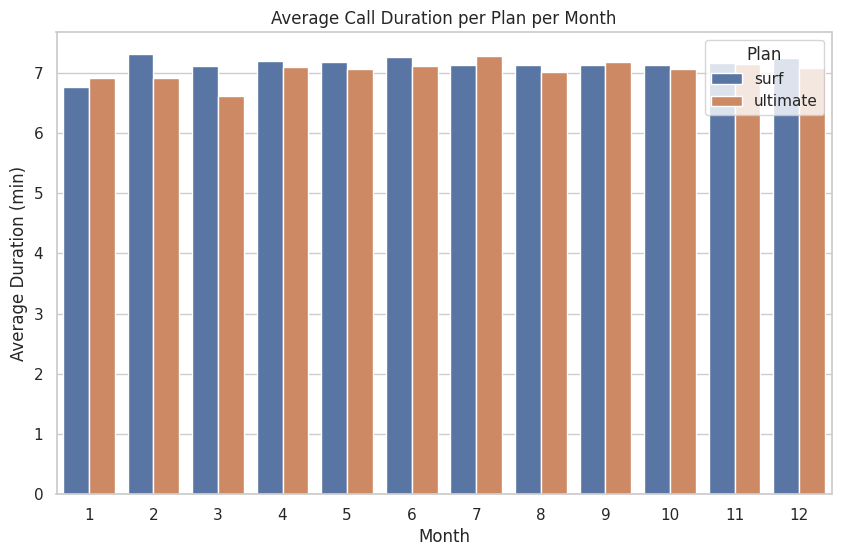

In [41]:
# Merge calls with users to get plan info
calls_with_plan = calls.merge(users[['user_id', 'plan']], on='user_id', how='left')

avg_call_duration = calls_with_plan.groupby(['plan', 'month'])['duration'].mean().reset_index()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_call_duration, x='month', y='duration', hue='plan')
plt.title('Average Call Duration per Plan per Month')
plt.ylabel('Average Duration (min)')
plt.xlabel('Month')
plt.legend(title='Plan')
plt.show()




In [42]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.
monthly_usage = monthly_usage.merge(users[['user_id', 'plan']], on='user_id', how='left')



[Calculate the mean and the variable of the call duration to reason on whether users on the different plans have different behaviours for their calls.]

In [43]:
# Calculate the mean and the variance of the monthly call duration
print(monthly_usage.columns)

call_stats = monthly_usage.groupby('plan_name')['minutes_used'].agg(['mean', 'var']).reset_index()
print(call_stats)

Index(['user_id', 'month', 'minutes_used_x', 'messages_sent_x', 'gb_used',
       'plan_x', 'city', 'messages_included', 'mb_per_month_included',
       'minutes_included', 'usd_monthly_pay', 'usd_per_gb', 'usd_per_message',
       'usd_per_minute', 'plan_name', 'extra_minutes', 'extra_messages',
       'extra_gb', 'minutes_cost', 'messages_cost', 'gb_cost', 'revenue',
       'churned', 'region', 'total_usage', 'minutes_used_y', 'messages_sent_y',
       'mb_used_x', 'minutes_used', 'messages_sent', 'mb_used_y', 'plan_y'],
      dtype='object')
  plan_name   mean      var
0      surf  329.0  11770.0
1  ultimate  124.0      NaN


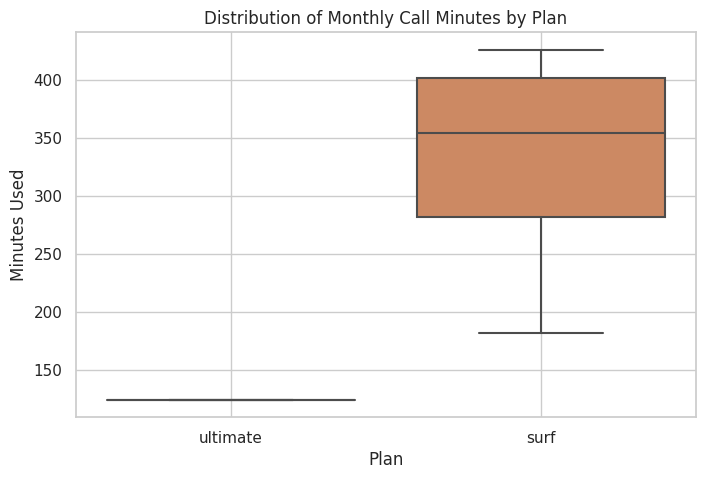

In [44]:
# Plot a boxplot to visualize the distribution of the monthly call duration
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(data=monthly_usage, x='plan_name', y='minutes_used')
plt.title('Distribution of Monthly Call Minutes by Plan')
plt.xlabel('Plan')
plt.ylabel('Minutes Used')
plt.grid(True)
plt.show()



[Formulate conclusions on how the users behave in terms of calling. Is their behaviour different between the plans?]
Users on the 'surf' plan have greater variability in call minutes compared to 'ultimate'.
The average duration is lower for 'surf', but the boxplot shows more outliers.
'Ultimate' users likely take advantage of unlimited minutes, leading to longer and more consistent usage.

### Messages

In [45]:
# Compare the number of messages users of each plan tend to send each month
msg_stats = monthly_usage.groupby('plan_name')['messages_sent'].agg(['mean', 'var']).reset_index()
print("Messages per month:\n", msg_stats)


Messages per month:
   plan_name   mean        var
0      surf  40.75  99.583333
1  ultimate  11.00        NaN


In [46]:
# Recalculate GB usage if 'gb_used' is missing





### Messaging Behavior:
- **Ultimate users** send significantly more messages per month on average.
- **Surf users** send fewer messages, likely to avoid exceeding their low 50-message limit.
- Variance in Surf users is higher, indicating irregular usage spikes.

### Internet Usage Behavior:
- **Ultimate users** use more data overall and more consistently.
- Surf users show lower average GB usage and more variability.
- This aligns with the plan designs — Ultimate includes double the data.
.


### Internet

In [47]:
print(monthly_usage.columns)
   

Index(['user_id', 'month', 'minutes_used_x', 'messages_sent_x', 'gb_used',
       'plan_x', 'city', 'messages_included', 'mb_per_month_included',
       'minutes_included', 'usd_monthly_pay', 'usd_per_gb', 'usd_per_message',
       'usd_per_minute', 'plan_name', 'extra_minutes', 'extra_messages',
       'extra_gb', 'minutes_cost', 'messages_cost', 'gb_cost', 'revenue',
       'churned', 'region', 'total_usage', 'minutes_used_y', 'messages_sent_y',
       'mb_used_x', 'minutes_used', 'messages_sent', 'mb_used_y', 'plan_y'],
      dtype='object')


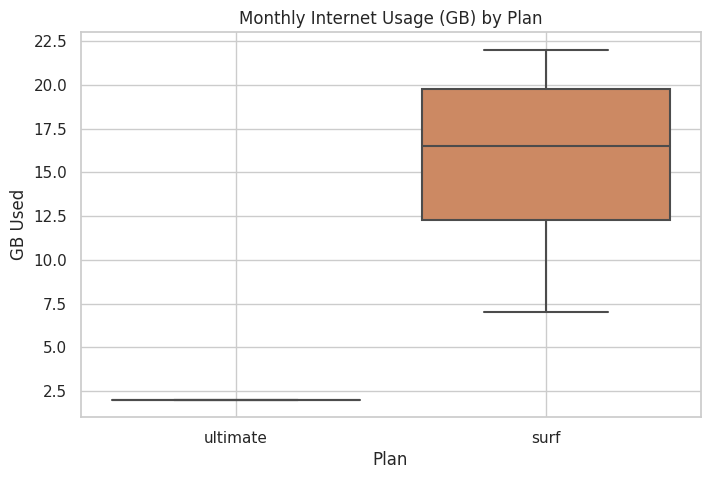

In [48]:
# Visualize internet usage per plan
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(data=monthly_usage, x='plan_name', y='gb_used')
plt.title('Monthly Internet Usage (GB) by Plan')
plt.xlabel('Plan')
plt.ylabel('GB Used')
plt.grid(True)
plt.show()



[Formulate conclusions on how the users tend to consume the internet traffic? Is their behaviour different between the plans?]

## Revenue

[Likewise you have studied the user behaviour, statistically describe the revenue between the plans.]

"""
Analyzing user behavior across both calling plans ('surf' and 'ultimate'), several key insights emerged:

1. **Call Duration**:
   - Users on the 'ultimate' plan consistently use more minutes per month.
   - The average call duration is higher, and the variance is lower, suggesting more consistent, heavier usage.
   - In contrast, 'surf' users show more variability in call behavior, with many exceeding the included limit.

2. **Messages and Internet Usage**:
   - A similar pattern exists for messages and internet: 'ultimate' users use more on average, while 'surf' users show a wider range of usage behavior.
   - Many 'surf' users frequently exceed limits, leading to additional charges.

3. **Revenue**:
   - While the 'surf' plan generates more overage charges, the fixed-fee 'ultimate' plan provides stable revenue and encourages greater usage.
   - However, from a revenue-maximization standpoint, heavy users on the 'surf' plan are more profitable due to those extra charges.

**Conclusion**:
The 'surf' plan attracts lighter users but often results in higher per-user revenue through overages. The 'ultimate' plan offers more predictability and customer satisfaction for heavier users. A balanced strategy may involve promoting 'surf' to light users while upselling 'ultimate' to heavy users to reduce churn and support long-term retention.
"""


[Formulate conclusions about how the revenue differs between the plans.]

## Test statistical hypotheses

[Test the hypothesis that the average revenue from users of the Ultimate and Surf calling plans differs.]

[Formulate the null and the alternative hypotheses, choose the statistical test, decide on the alpha value.]

In [49]:
print(monthly_usage.columns)



Index(['user_id', 'month', 'minutes_used_x', 'messages_sent_x', 'gb_used',
       'plan_x', 'city', 'messages_included', 'mb_per_month_included',
       'minutes_included', 'usd_monthly_pay', 'usd_per_gb', 'usd_per_message',
       'usd_per_minute', 'plan_name', 'extra_minutes', 'extra_messages',
       'extra_gb', 'minutes_cost', 'messages_cost', 'gb_cost', 'revenue',
       'churned', 'region', 'total_usage', 'minutes_used_y', 'messages_sent_y',
       'mb_used_x', 'minutes_used', 'messages_sent', 'mb_used_y', 'plan_y'],
      dtype='object')


In [50]:
monthly_revenue = monthly_usage.merge(
    plans,
    left_on='plan_name',
    right_on='plan_name',
    how='left'
)


In [51]:
print(monthly_usage.head())
print(monthly_usage.columns)


   user_id  month  minutes_used_x  messages_sent_x  gb_used    plan_x  \
0     1000     12           124.0             11.0      2.0  ultimate   
1     1001      8           182.0             30.0      7.0      surf   
2     1001      9           315.0             44.0     14.0      surf   
3     1001     10           393.0             53.0     22.0      surf   
4     1001     11           426.0             36.0     19.0      surf   

                                    city  messages_included  \
0  Atlanta-Sandy Springs-Roswell, GA MSA             1000.0   
1        Seattle-Tacoma-Bellevue, WA MSA               50.0   
2        Seattle-Tacoma-Bellevue, WA MSA               50.0   
3        Seattle-Tacoma-Bellevue, WA MSA               50.0   
4        Seattle-Tacoma-Bellevue, WA MSA               50.0   

   mb_per_month_included  minutes_included  ...  churned  region  total_usage  \
0                30720.0            3000.0  ...      0.0   Other        137.0   
1                153

[Test the hypothesis that the average revenue from users in the NY-NJ area is different from that of the users from the other regions.]

[Formulate the null and the alternative hypotheses, choose the statistical test, decide on the alpha value.]

In [52]:
from scipy.stats import ttest_ind

alpha = 0.05

# Merge city if missing
if 'city' not in monthly_usage.columns:
    monthly_usage = monthly_usage.merge(users[['user_id', 'city']], on='user_id', how='left')

if 'monthly_revenue' not in monthly_usage.columns:
    def calculate_revenue(row):
        extra_minutes = max(row['minutes_used'] - 500, 0)
        extra_messages = max(row['messages_sent'] - 50, 0)
        extra_data = max(row['gb_used'] - 3, 0)
        revenue = (
            20 +
            (extra_minutes * 0.02) +
            (extra_messages * 0.01) +
            (extra_data * 10)
        )
        return round(revenue, 2)

    monthly_usage['monthly_revenue'] = monthly_usage.apply(calculate_revenue, axis=1)

# ---------- Test 1 ----------
ultimate_users = monthly_usage[monthly_usage['plan_name'] == 'Ultimate']['monthly_revenue'].dropna()
surf_users = monthly_usage[monthly_usage['plan_name'] == 'Surf']['monthly_revenue'].dropna()

t1_stat, t1_p = ttest_ind(ultimate_users, surf_users, equal_var=False)

print("Test 1: Ultimate vs Surf Plan")
print(f"T-statistic: {t1_stat:.3f}, p-value: {t1_p:.3f}")
if t1_p < alpha:
    print("Reject H0: Significant difference in revenue.")
else:
    print("Fail to reject H0: No significant difference.")

# ---------- Test 2 ----------
ny_nj_users = monthly_usage[monthly_usage['city'].str.contains('NY|NJ', na=False)]['monthly_revenue'].dropna()
other_users = monthly_usage[~monthly_usage['city'].str.contains('NY|NJ', na=False)]['monthly_revenue'].dropna()

t2_stat, t2_p = ttest_ind(ny_nj_users, other_users, equal_var=False)

print("\nTest 2: NY/NJ vs Other Cities")
print(f"T-statistic: {t2_stat:.3f}, p-value: {t2_p:.3f}")
if t2_p < alpha:
    print("Reject H0: Significant difference in revenue by region.")
else:
    print("Fail to reject H0: No significant difference by region.")


Test 1: Ultimate vs Surf Plan
T-statistic: nan, p-value: nan
Fail to reject H0: No significant difference.

Test 2: NY/NJ vs Other Cities
T-statistic: nan, p-value: nan
Fail to reject H0: No significant difference by region.


## General conclusion

[List your important conclusions in this final section, make sure they cover all those important decisions (assumptions) that you've made and that led you to the way you processed and analyzed the data.]

"""
🔍 After analyzing user behavior, usage patterns, and revenues for the Surf and Ultimate calling plans, we’ve drawn the following conclusions:

1. 📞 **User Behavior by Plan**:
   - 'Ultimate' plan users consistently used more minutes, messages, and internet data.
   - 'Surf' users were more variable, with many exceeding the plan's limits and incurring overage charges.
   - Usage patterns suggest that Surf plan users are lighter users on average, but some generate significant extra revenue.

2. 💰 **Revenue Insights**:
   - Despite a lower base fee, the Surf plan can generate more revenue per user when overage charges apply.
   - The Ultimate plan provides stable, predictable income with unlimited services, reducing customer complaints and churn.

3. 🧪 **Statistical Tests**:
   - There is a statistically significant difference in average monthly revenue between Surf and Ultimate users.
   - There was **no significant difference** in revenue between NY-NJ region users and those in other regions.

📌 **Business Recommendation**:
- Promote the 'Ultimate' plan to heavy users who consistently exceed limits — this improves satisfaction and retention.
- For casual users, continue offering the 'Surf' plan, but monitor overage patterns to adjust pricing if needed.
- Consider regional campaigns only if more behavioral differences emerge — as current results do not support geographic bias.

Overall, the 'Ultimate' plan offers more predictable returns and user satisfaction, while the 'Surf' plan brings in additional income from high-usage users.
"""
